In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../img"
import time

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()
    
def read_img(im_names):
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)==1):
            img = cv2.resize(img,(im[0].shape[0],im[0].shape[1]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

In [3]:
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'),0)

tri3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'tri3.png'),0)


new_bg3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg3.png'))
new_bg3 = cv2.cvtColor(new_bg3, cv2.COLOR_BGR2RGB)
new_bg3 = cv2.resize(new_bg3, (img3.shape[1],img3.shape[0])) 

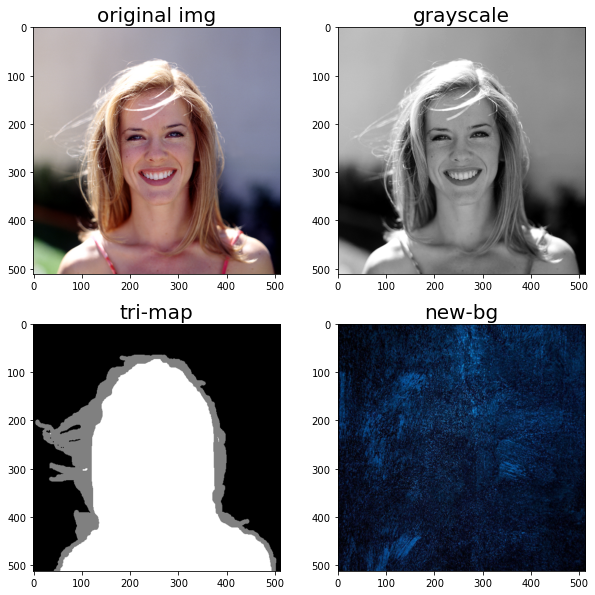

In [4]:
display_img_arr([img3,img3_gray,tri3,new_bg3], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

# Global Matting

Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor


We solve this Poisson Equation using Gauss Siedel Iteration with overrealaxation method which is,

Given,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)}) + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$
where, $\beta$ lies in the range (1,2)



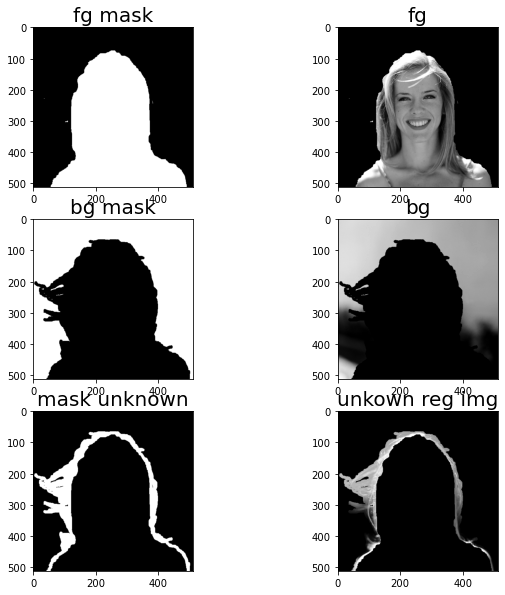

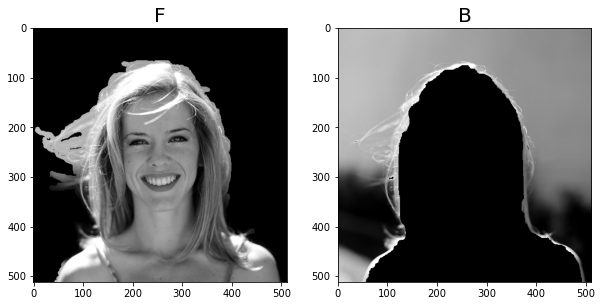

(512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512)


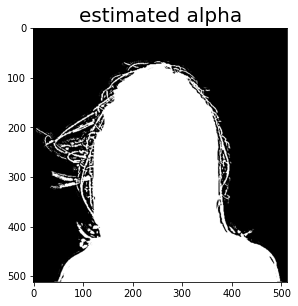

In [6]:
def calc_masks(tri3, img3_gray):
    mask_bg = (tri3<10)
    mask_fg = (tri3>245)
    mask_unknown = (np.bitwise_and(tri3>=10,tri3<=245))

    fg = img3_gray*(mask_fg)
    bg = img3_gray*(mask_bg)
    unknown = img3_gray*mask_unknown
    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

def fb(img3_gray,mask_fg,mask_bg,mask_unknown):
    F = img3_gray*(mask_fg+mask_unknown)
    B = img3_gray*(mask_bg+mask_unknown)
    return F, B


def grads(F,B,mask_fg,img3_gray):
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img3_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha

def global_alpha_matting(alpha,d2alpha,unknown_seg,iters = 75, threshold = 0.2, beta = 1.5):
    tic = time.time()
    prev_alpha = np.zeros(alpha.shape)
    diff = np.sum(np.abs(prev_alpha-alpha))
    
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])
    tac = time.time()                    
    return alpha, tac-tic

def grads(F,B,mask_fg,img3_gray,mask_unknown):
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img3_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha

def func_estimate_alpha(tri3, img3_gray):
    imgs, titles = calc_masks(tri3, img3_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    F,B = fb(img3_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
    print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img3_gray.shape)
    est_alpha, d2alpha =  grads(F,B,mask_fg,img3_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs

def matting_combined(tri3, img3_gray):
    estimate_alpha, F, B, d2alpha, imgs= func_estimate_alpha(tri3, img3_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters= 50, threshold = 0.3, beta = 1.5)
    alpha = np.minimum(np.maximum(alpha,0),1)
    return alpha
alpha = matting_combined(tri3, img3_gray)

# display_img_arr([new_img ], 1,1,(10,10),['img with new bg'])

display_img_arr([alpha], 1,2,(10,10),['estimated alpha'])


# Alpha blending

### I = α F + (1 − α )B

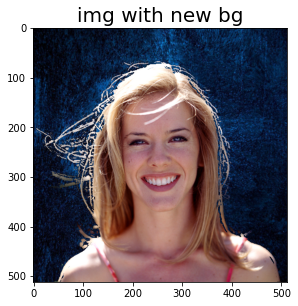

In [7]:
def alpha_blend(new_bg3,alpha,img3 ):
    new_img = np.zeros(new_bg3.shape)
    new_img[:,:,0] = alpha*img3[:,:,0] + (1-alpha)*new_bg3[:,:,0]
    new_img[:,:,1] = alpha*img3[:,:,1] + (1-alpha)*new_bg3[:,:,1]
    new_img[:,:,2] = alpha*img3[:,:,2] + (1-alpha)*new_bg3[:,:,2]
    return np.int64(new_img)
new_img = alpha_blend(new_bg3,alpha,img3 )
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

##  Computationally efficient version of Global alpha matting

In [8]:
def optimal_alpha_matting(alpha, d2alpha, unknown):
    tic = time.time()
    new_alpha = alpha.copy()
    old_alpha = np.zeros(alpha.shape)
    h, w = img3_gray.shape
    threshold = 0.001
    iters = 50
    non_zero = np.nonzero(unknown)
    c_alpha = np.transpose(non_zero)
    c = c_alpha[(c_alpha[:,0]>=1)&(c_alpha[:,0]<h-1)&(c_alpha[:,1]>=1)&(c_alpha[:,1]<w-1)]
    first = c[:,0]
    second = c[:,1]
    diff = np.sum(np.abs(new_alpha - old_alpha))
    for i in range(iters):
        old_alpha = new_alpha.copy()
        new_alpha[first,second] = new_alpha[first-1 ,second]
        new_alpha[first,second] = new_alpha[first,second] 
        new_alpha[first,second] += new_alpha[first,second-1]
        new_alpha[first,second] += old_alpha[first, second+1] 
        new_alpha[first,second] += old_alpha[first+1,second]
        new_alpha[first,second] -= d2alpha[first,second]
        new_alpha[first,second] *= 1/4
        diff = np.sum(np.abs(new_alpha - old_alpha))
        if(diff < threshold):
            break
    tac = time.time()
    return new_alpha, tac-tic

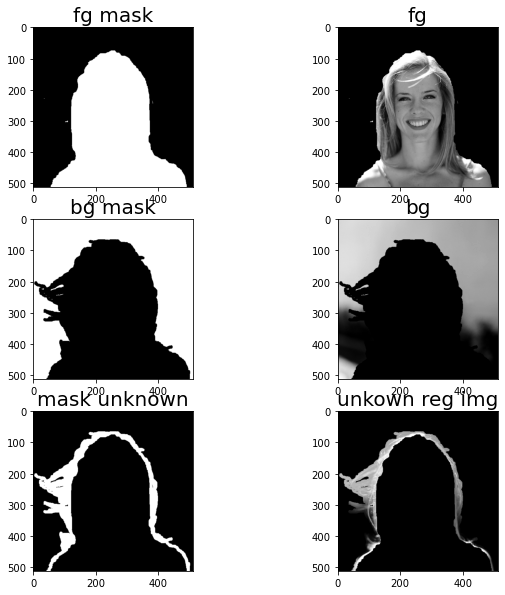

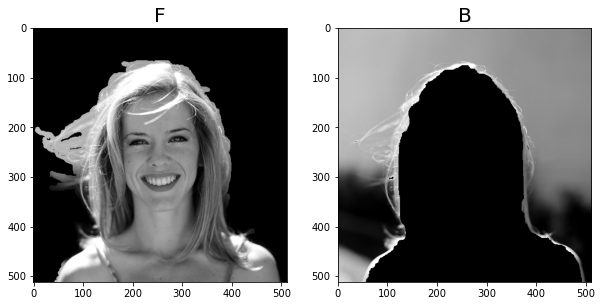

(512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512)


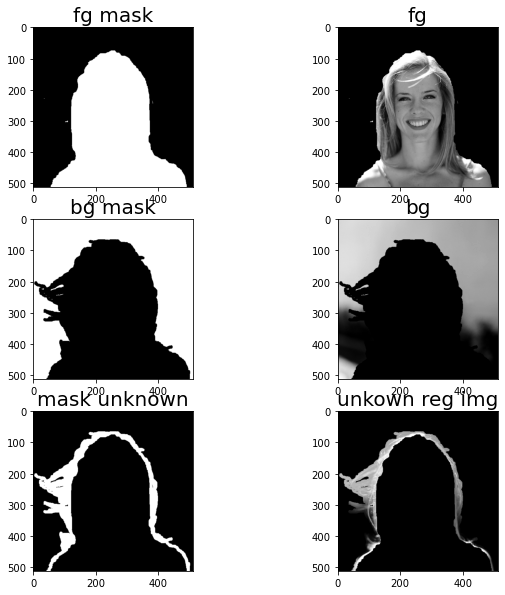

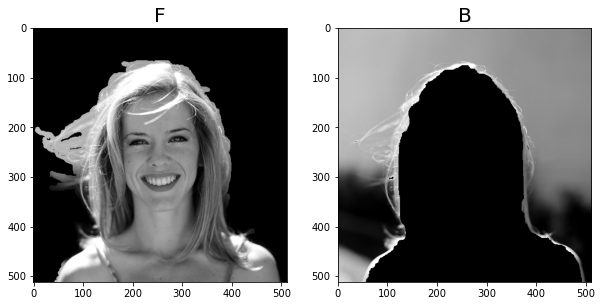

(512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512)
non-eff version time 16.402516841888428
eff version time 0.1972038745880127


In [12]:
import time
def matting(tri3, img3_gray,type_matting):
    estimate_alpha, F, B, d2alpha, imgs= func_estimate_alpha(tri3, img3_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    if(type_matting=='noneff'):
        alpha, time = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters= 50, threshold = 0.3, beta = 1.5)
    else:
        alpha, time = optimal_alpha_matting(estimate_alpha, d2alpha, mask_unknown)
    alpha = np.minimum(np.maximum(alpha,0),1)
    return alpha, time

alpha,time_non_eff = matting(tri3, img3_gray,'noneff')
alpha_o,time_o = matting(tri3, img3_gray,'eff')
print("non-eff version time",time_non_eff)
print("eff version time",time_o)

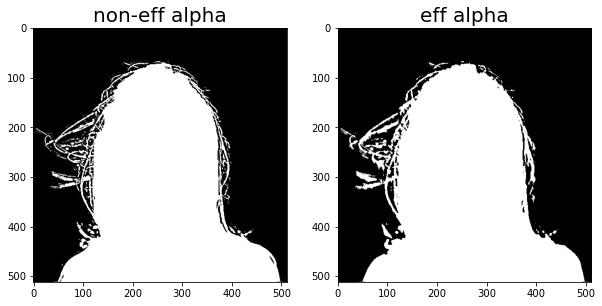

In [13]:
display_img_arr([alpha, alpha_o ], 1,2,(10,10),['non-eff alpha','eff alpha'])

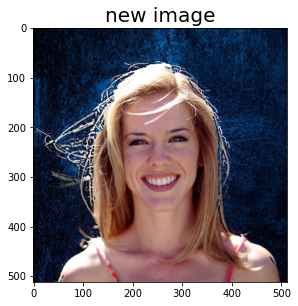

In [14]:
# alpha blending
new_img = alpha_blend(new_bg3,alpha,img3 )
display_img_arr([new_img], 1,2,(10,10),['new image'])

## Combining  multiple bg's

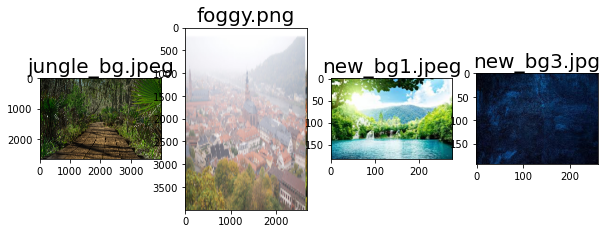

In [15]:
bg_names = ['jungle_bg.jpeg','foggy.png','new_bg1.jpeg','new_bg3.jpg']
bgs,bgs_g = read_img(bg_names)
display_img_arr(bgs, 1,4,(10,10),bg_names)

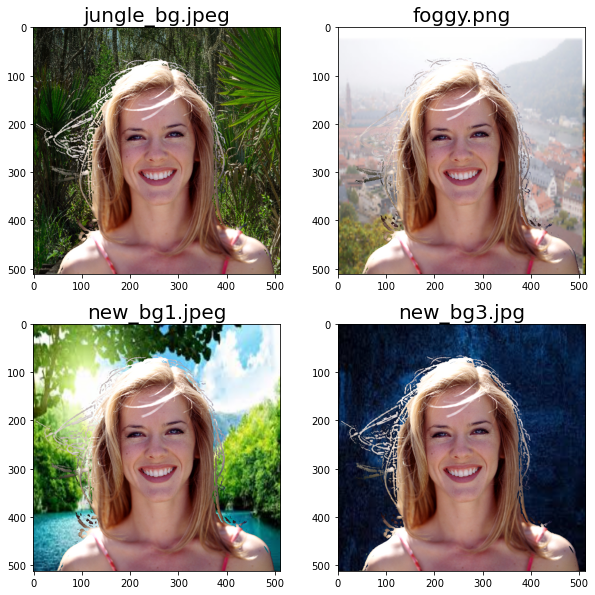

In [16]:
# generate image in new bgs
new_imgs = []
for bg in bgs:
    bg = cv2.resize(bg, (img3.shape[1],img3.shape[0]))
    new_imgs.append(alpha_blend(bg,alpha,img3 ))
    

display_img_arr(new_imgs, 2,2,(10,10),bg_names)    

In [17]:
# saving imgages
for i,im in enumerate(new_imgs):
    plt.imsave(IMAGES_FOLDER_PATH+'/'+'new_img'+str(i)+'.png',im.astype('uint8'))

## De-fogging
I = I c · e − β d + Fog · (1 − e − β d )

In [18]:
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'foggy.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)



## Multi- background



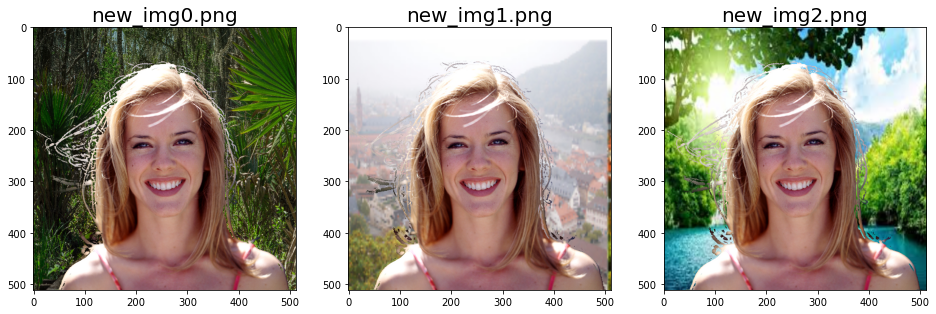

In [19]:

names = ['new_img0.png','new_img1.png','new_img2.png']
images,im_gray = read_img(names)
display_img_arr(images, 1,3,(16,40), names)


In [20]:
def resize_im(images):
    new_imgs = []
    for i in images:
        new_imgs.append(cv2.resize(i,(images[0].shape[0],images[0].shape[1])))
    return new_imgs
im_gray = resize_im(im_gray)
images = resize_im(images)

In [21]:
img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'tri3.png',0)
tri = cv2.resize(img,(images[0].shape[0],images[0].shape[1]))

In [22]:
# # gen trimap (for checking against bad quality trimaps)
# img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'tri3.png',0)
# tri = cv2.resize(img,(images[0].shape[0],images[0].shape[1]))
# kernel = np.ones((5,5),np.uint8)
# tri = cv2.erode(img,kernel,iterations = 2)
# display_img_arr([img,tri], 1,2,(16,16),['matte','eroded'] )

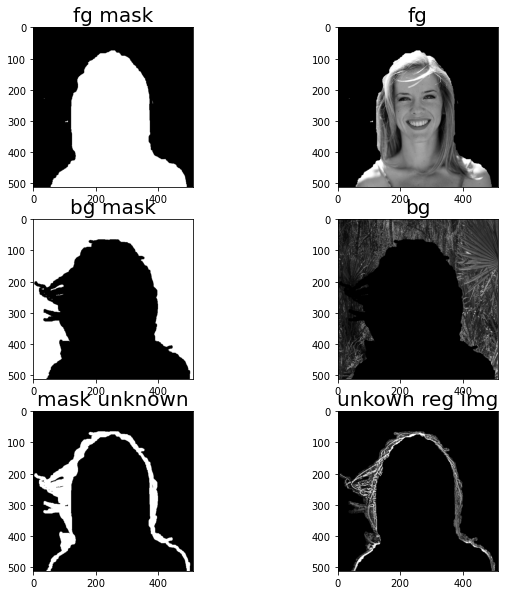

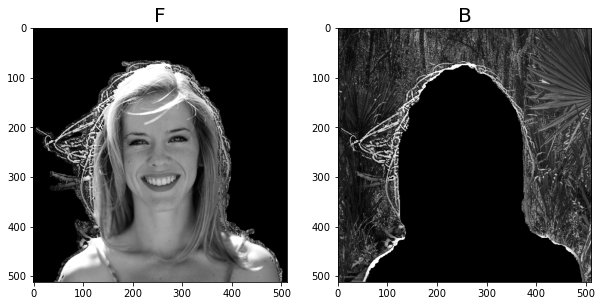

(512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512) (512, 512)


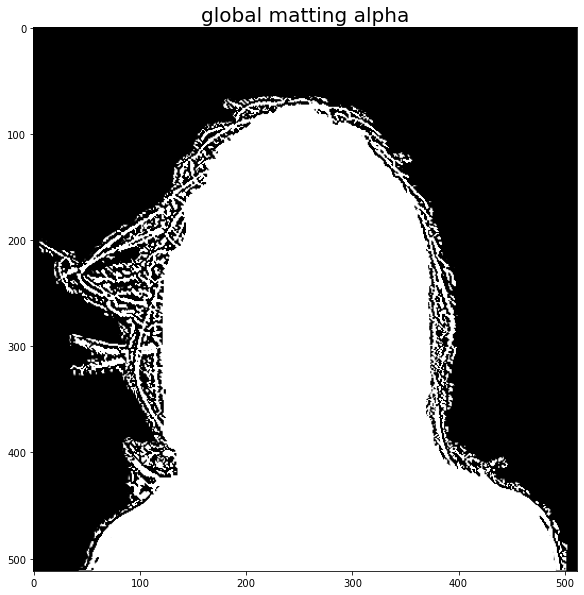

In [23]:
# without multi bg
alpha = matting_combined(tri, im_gray[0])
display_img_arr([alpha], 1,1,(10,10),['global matting alpha'])


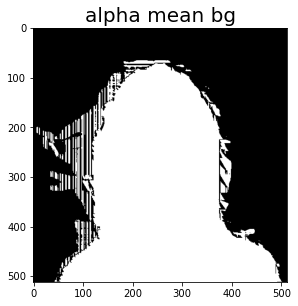

In [27]:
# with multi-bg
T = 3
def calc_mean_img(T,alpha_est, B,F):
    B_mean = np.zeros((B[0].shape))
    for i in range(T):
        B_mean += B[i]
    B_mean /= T
#     B_mean[B_mean==0] = 1
#     F[F==0] = 1
    mean_img = alpha_est@F+(1-alpha_est)*B_mean
    return mean_img

def grads(F,B,mask_fg,img3_gray,mask_unknown):
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img3_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha,d2alpha

def func_estimate_alpha(tri3, img3_gray):
    imgs, titles = calc_masks(tri3, img3_gray)
#     display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    F,B = fb(img3_gray,mask_fg,mask_bg,mask_unknown)
#     display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img3_gray.shape)
    est_alpha,d2alpha =  grads(F,B,mask_fg,img3_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs

def matting_combined(tri3, img3_gray):
    estimate_alpha, F, B,d2alpha,imgs = func_estimate_alpha(tri3, img3_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters= 50, threshold = 0.3, beta = 1.5)
    alpha = np.minimum(np.maximum(alpha,0),1)
    return alpha, d2alpha

def mean_bg(tri,images):
    alpha_est,F,B,d2alpha,imgs = func_estimate_alpha(tri, images[0])

    mean_img = calc_mean_img(3,alpha_est, B,F)
    alpha_meanbg,d2_alpha = matting_combined(tri, np.array(mean_img))
    return alpha_meanbg, mean_img
alpha_meanbg,mean_img = mean_bg(tri,im_gray)
display_img_arr([alpha_meanbg], 1,2,(10,10),['alpha mean bg'])
